# Linear regression


In [0]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt

from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data


The following data are available for 1260 respondents:

* salary per hour of work, $;
* work experience, years;
* education, years;
* external attractiveness, in points from 1 to 5;
* binary signs: gender, marital status, health status (good / bad), union membership, skin color (white / black), employment in the service sector (yes / no).

It is required to evaluate the effect of external attractiveness.

Hamermesh D.S., Biddle J.E. (1994) Beauty and the Labor Market, American Economic Review, 84, 1174–1194.

Data:

In [3]:
raw = pd.read_csv("https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_12/datasets/beauty.csv", sep=";", index_col=False) 
raw.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


Let us look at the matrix of scattering diagrams by quantitative criteria:

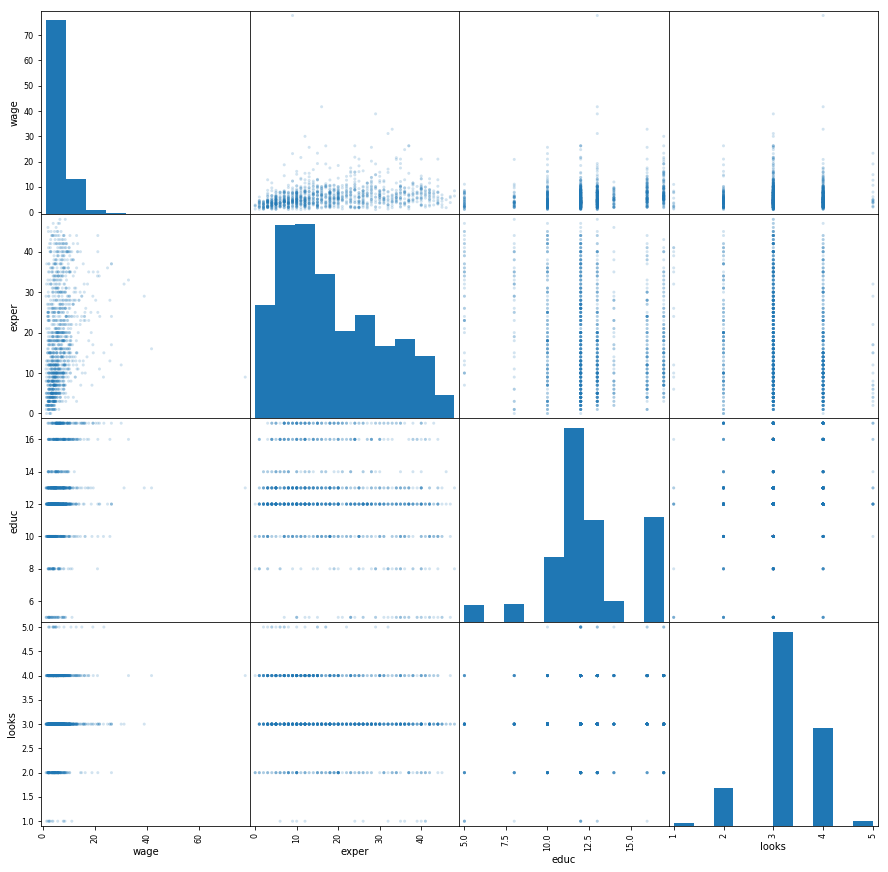

In [5]:
pd.plotting.scatter_matrix(raw[['wage', 'exper', 'educ', 'looks']], alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

Let us evaluate the balance of the sample by categorical criteria:

In [7]:
print (raw.union.value_counts())
print (raw.goodhlth.value_counts())
print (raw.black.value_counts())
print (raw.female.value_counts())
print (raw.married.value_counts())
print (raw.service.value_counts())

0    917
1    343
Name: union, dtype: int64
1    1176
0      84
Name: goodhlth, dtype: int64
0    1167
1      93
Name: black, dtype: int64
0    824
1    436
Name: female, dtype: int64
1    871
0    389
Name: married, dtype: int64
0    915
1    345
Name: service, dtype: int64


Each sign has all the meanings many times, so everything is allright.

## Preprocessing

In [0]:
data = raw

Let's look at the distribution of the target attribute - the level of wages:

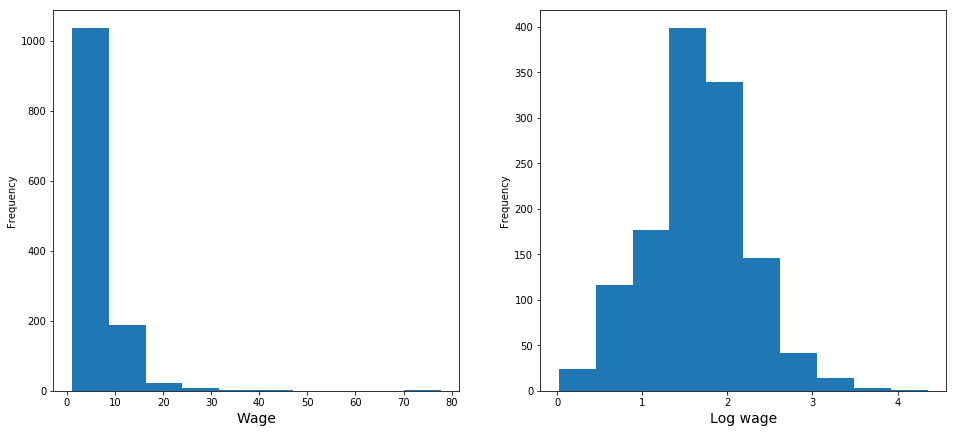

In [10]:
plt.figure(figsize(16,7))
plt.subplot(121)
data['wage'].plot.hist()
plt.xlabel('Wage', fontsize=14)

plt.subplot(122)
np.log(data['wage']).plot.hist()
plt.xlabel('Log wage', fontsize=14)
pylab.show()

One person in the sample receives 77.72 \$ per hour, the rest - less than 45 \$; we’ll remove this person so that the regression does not retune to him.

In [0]:
data = data[data['wage'] < 77]

Let's look at the distribution of attractiveness ratings:

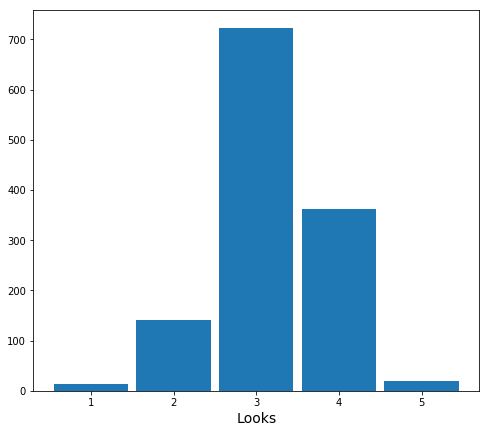

In [12]:
plt.figure(figsize(8,7))
data.groupby('looks')['looks'].agg(lambda x: len(x)).plot(kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.xlabel('Looks', fontsize=14)
pylab.show()

In groups looks = 1 and looks = 5 there are too few observations. We turn the looks attribute into a categorical one and encode using dummy variables:

In [13]:
data['belowavg'] = data['looks'].apply(lambda x : 1 if x < 3 else 0)
data['aboveavg'] = data['looks'].apply(lambda x : 1 if x > 3 else 0)
data.drop('looks', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

In [14]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


## Creating a model

### Simple model

Let's create a simple linear model with all features.

In [16]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +'\
                    'service + educ + belowavg + aboveavg', 
             data=data)
fitted = m1.fit()
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Sat, 07 Sep 2019   Prob (F-statistic):           1.42e-75
Time:                        10:25:24   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5898      0.743     -0.793      0.4

Let's look at the distribution of residues:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


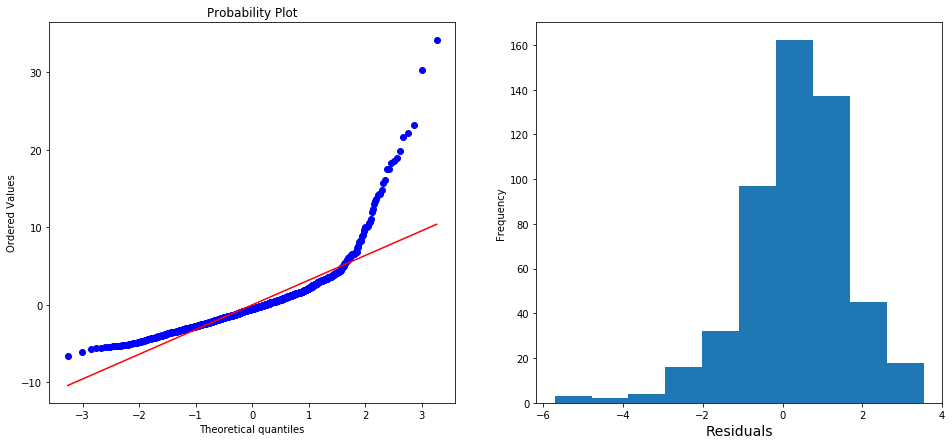

In [17]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

It is beveled, like the original sign. In such situations, it often helps to move from the regression of the original sign to the regression of its logarithm.

### Logarithm response

In [19]:
m2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married +'\
                            'service + educ + belowavg + aboveavg', data=data)
fitted = m2.fit()
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Sat, 07 Sep 2019   Prob (F-statistic):          1.18e-123
Time:                        10:26:14   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


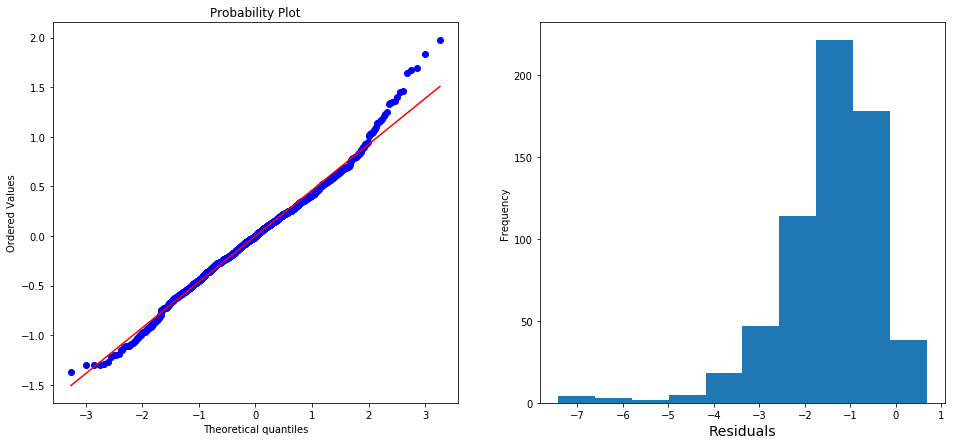

In [20]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Now it’s better. Let us now look at the dependence of residues on continuous signs:

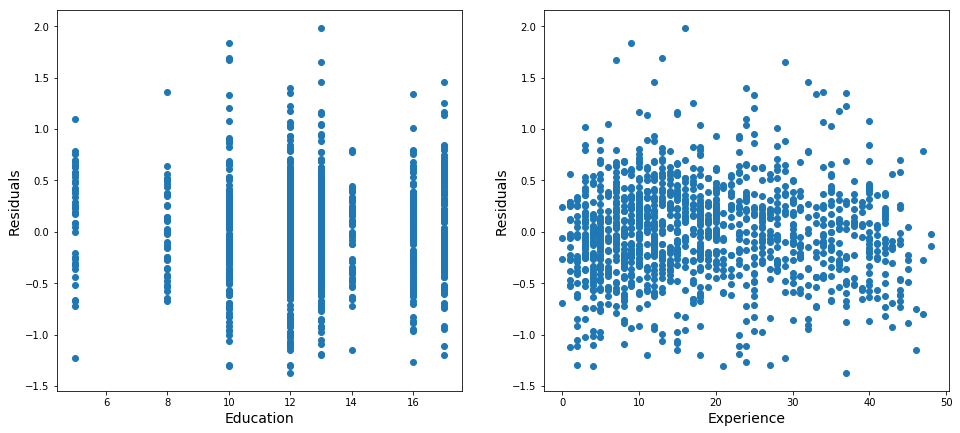

In [21]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

The second graph shows the quadratic dependence of the residuals on the work experience. Let’s try to add a square of work experience to the signs to take this effect into account.

### Adding a square of experience

In [23]:
m3 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m3.fit()
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Sat, 07 Sep 2019   Prob (F-statistic):          3.19e-131
Time:                        10:26:55   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


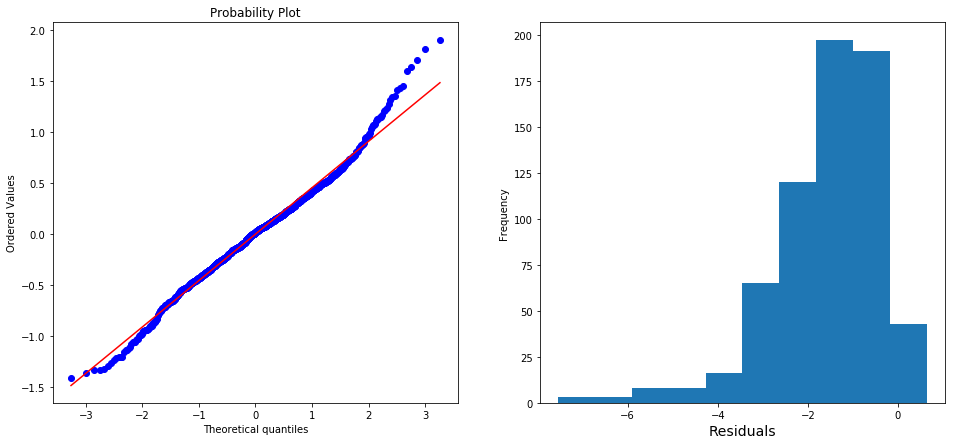

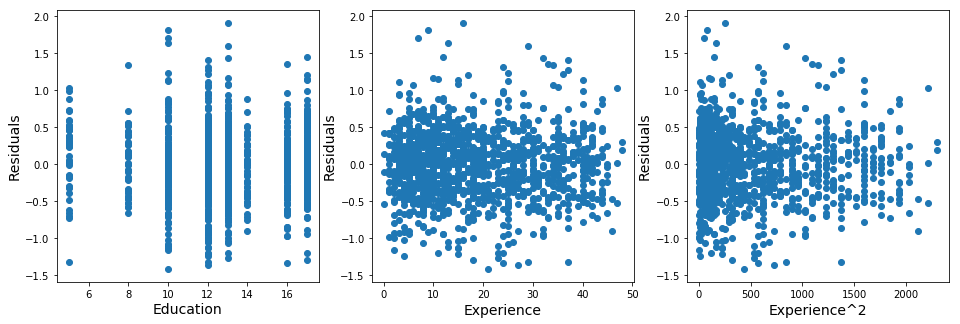

In [24]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.figure(figsize(16,5))
plt.subplot(131)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
scatter(data['exper']**2,fitted.resid)
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

We use the Broysch-Pagan criterion to check the homoskedasticity of errors:

In [26]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000004


Errors are heteroskedasticheskie, which means that the significance of the signs can be determined incorrectly. Make White's amendment:

In [27]:
m4 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m4.fit(cov_type='HC1')
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Sat, 07 Sep 2019   Prob (F-statistic):          4.23e-146
Time:                        10:28:24   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


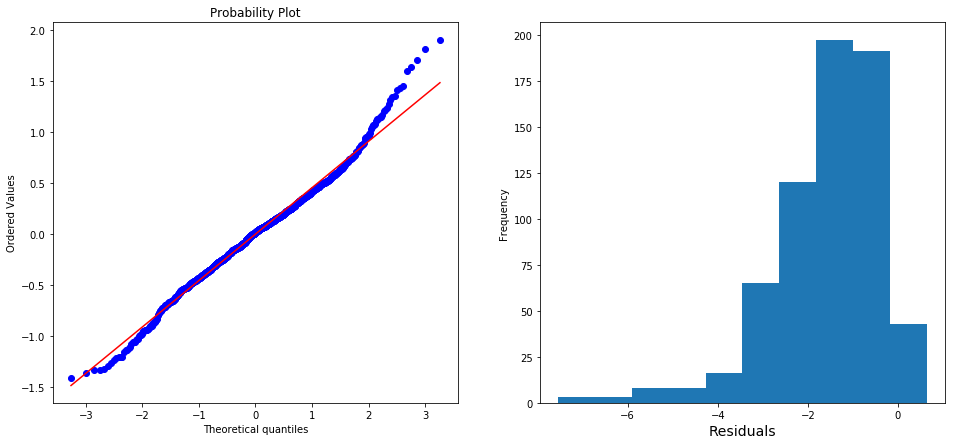

In [28]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

### Removing insignificant signs

In the previous model, they are insignificant: skin color, health, marital status. Let's remove them. The attractiveness indicator above the average is also insignificant, but we will not delete it, because this is one of the variables by which you need to answer the question at the end.

In [29]:
m5 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + female + service + educ +'\
                            'belowavg + aboveavg', data=data)
fitted = m5.fit(cov_type='HC1')
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     121.1
Date:                Sat, 07 Sep 2019   Prob (F-statistic):          6.49e-150
Time:                        10:29:05   Log-Likelihood:                -799.30
No. Observations:                1259   AIC:                             1617.
Df Residuals:                    1250   BIC:                             1663.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3906      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


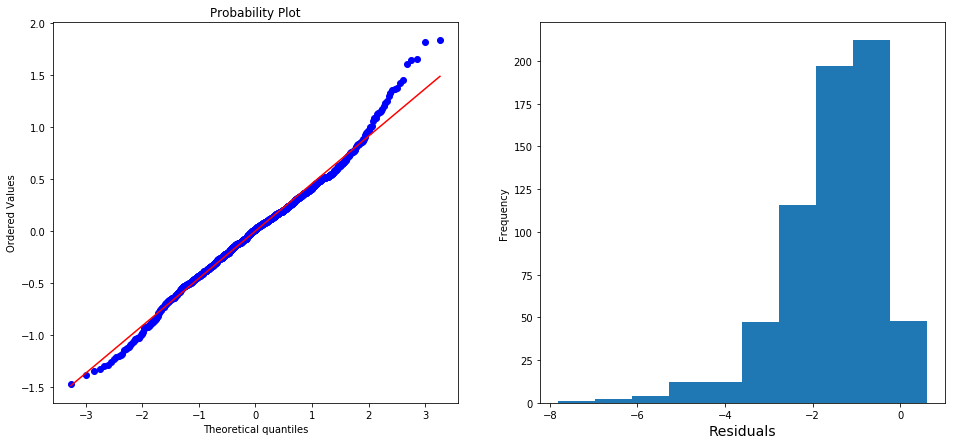

In [30]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Let's see if the model became much worse after removing three signs, using the Fisher criterion:

In [31]:
print ("F=%f, p=%f, k1=%f" % m4.fit().compare_f_test(m5.fit()))

F=1.611478, p=0.184911, k1=3.000000


It didn’t.

Let’s check if there are any observations that influence the regression equation too much:

<Figure size 576x504 with 0 Axes>

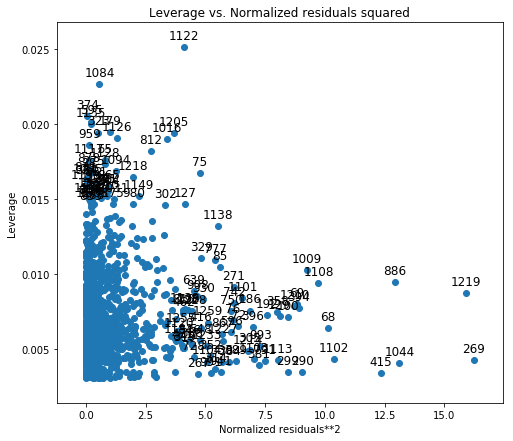

In [32]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

In [33]:
data.loc[[1122]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
1122,6.25,47,0,0,1,1,1,0,5,0,1


In [34]:
data.loc[[269]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
269,41.67,16,0,0,0,0,1,0,13,0,1


## Results

The final model explains 40% of the variation in the logarithm of the response.

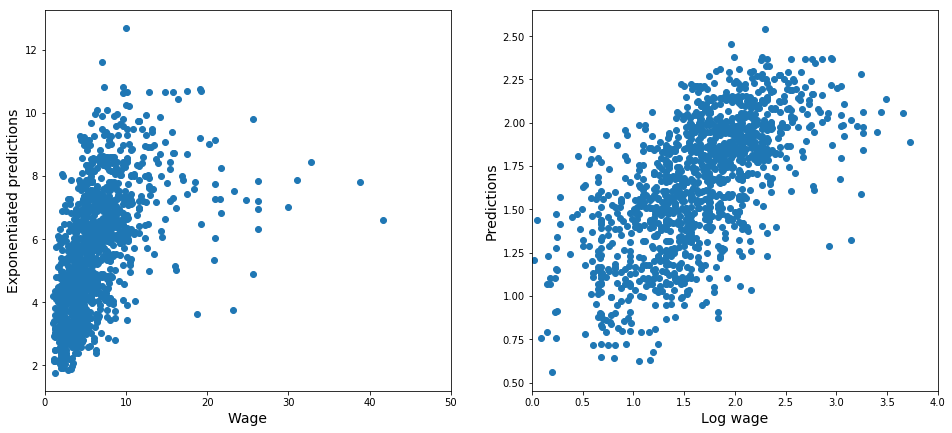

In [35]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['wage'],np.exp(fitted.fittedvalues))
plt.xlabel('Wage', fontsize=14)
plt.ylabel('Exponentiated predictions', fontsize=14)
plt.xlim([0,50])

plt.subplot(122)
scatter(np.log(data['wage']),fitted.fittedvalues)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,4])
pylab.show()

With the attractiveness factors of interest to us, the coefficients are -0.1307 (below average) and -0.0010 (above average).

Since the regression was done on the logarithm of the response, they can be interpreted as a percentage increase. Taking into account additional factors, representatives of the general population from which the sample is taken, get on average:

* 13% less if their attractiveness is below average (p = 0.001, 95% confidence interval - [5.21]%);
* the same if their attractiveness is above average (p = 0.972, 95% confidence interval - [-6.6]%).